# Preparaion for work

In [ ]:
!pip install easyimages

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MS15bAajd3WoxFsALdhF")
project = rf.workspace("innopolis-university-5kqay").project("grocery-products-detection")
dataset = project.version(5).download("coco")

In [ ]:
!pip install pycocotools matplotlib opencv-python-headless

In [ ]:
!pip install mxnet

In [ ]:
!pip install d2l

In [41]:
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
from numpy import random
import numpy as np

In [42]:
dataDir = '/content/Grocery-products-detection-5'  # Path to the COCO dataset directory

In [43]:
%matplotlib inline

# Pictures analysis

Metrics for analysis

In [44]:
# Load image information
img_aspect_ratio = []
# Display the image with annotations
bounding_box_aspect_ratio = []

bounding_box_area = {}

mask_area = {}

## Displaying random sample and collecting data from test

In [45]:
def display_sample(dataType):
  annFile = f'{dataDir}/{dataType}/_annotations.coco.json'

  coco = COCO(annFile)
  # Define the number of images to display in a row
  img_ids = random.choice(coco.getImgIds(), 10)
  # Load image information

  # Load and display annotations for the image
  fig, axes = plt.subplots(1, 10, figsize=(16, 16))
  # Display the image with annotations
  for i in range(10):
    img_info = coco.loadImgs([img_ids[i]])[0]
    img_path = f'{dataDir}/{dataType}/{img_info["file_name"]}'
    img = cv2.imread(img_path)

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"Image {i + 1}")
    plt.axis('off')

  plt.show()
  collect_boxes_data(coco)
  return coco

In [46]:
def collect_boxes_data(coco):
  img_ids = coco.getImgIds()
  for i in img_ids:
    img_info = coco.loadImgs([i])[0]
    ann_ids = coco.getAnnIds(imgIds=i)
    target_info = coco.loadAnns(ann_ids)
    img_aspect_ratio.append(img_info['width'] / img_info['height'])
    for j in target_info:
      category = j['category_id']
      if category in bounding_box_area.keys():
        bounding_box_area[category].append(j['bbox'][2] * j['bbox'][3])
      else:
        bounding_box_area[category] = [j['bbox'][2] * j['bbox'][3]]

      bounding_box_aspect_ratio.append(j['bbox'][2] / j['bbox'][3])

      if category in mask_area.keys():
        mask_area[category].append(j['area'])
      else:
        mask_area[category] = [j['area']]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


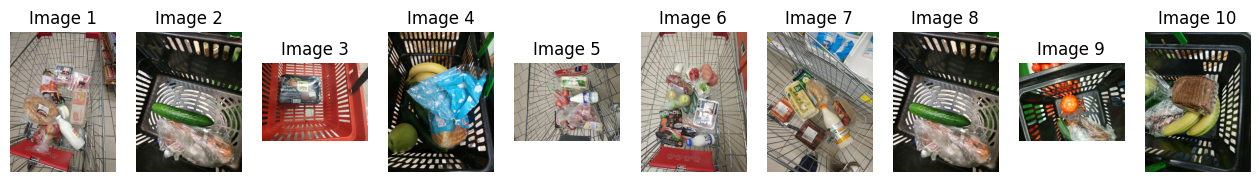

In [47]:
dataType = 'test'  # Specify 'train2017' or 'val2017'
display_sample(dataType)

## Collecting data about targets and images from test sample

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


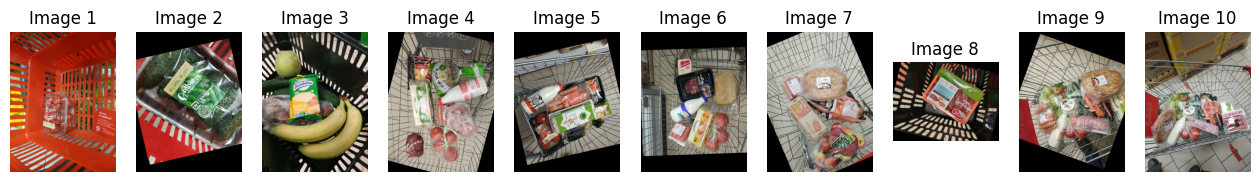

In [48]:
dataType = 'train'  # Specify 'train2017' or 'val2017'
display_sample(dataType)

## Displaying random sample from validation

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


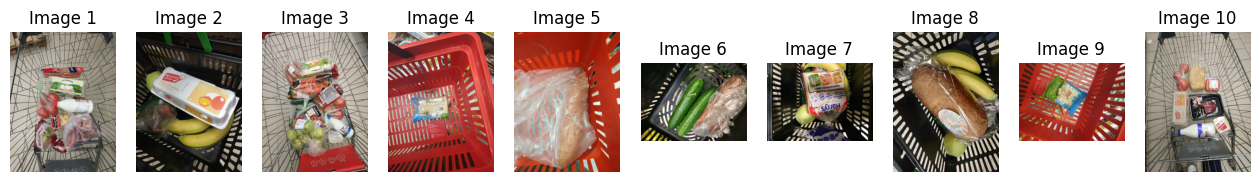

In [49]:
dataType = 'valid'  # Specify 'train2017' or 'val2017'
coco = display_sample(dataType)

## Image aspect ratio

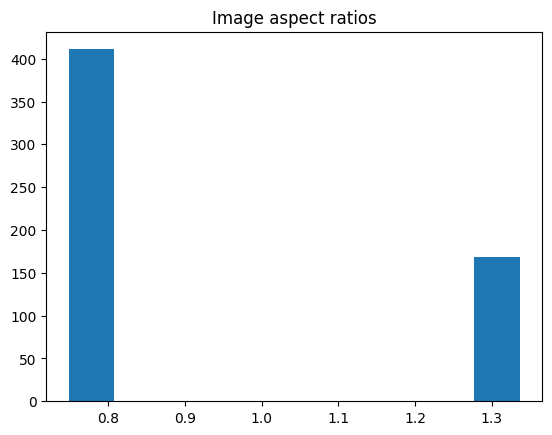

In [50]:
counts, bins = np.histogram(img_aspect_ratio)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Image aspect ratios')
plt.show()

## Conclusion about pictures

There is no corrupt images and no artifact. In addition, aspect ratio of most images are uniformly distributed (most of the images have the same dimensions). More accurately, there are only 2 aspect ratios in dataset, and these values are inverse (multiplication between these numbers gives 1).

# Bounding box analysis

In [51]:
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

np.set_printoptions(2)  # Simplify printing accuracy
npx.set_np()

In [52]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        bbox = bbox.asnumpy()
        color = colors[i % len(colors)]
        rect = d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], fill=False, edgecolor=color, linewidth=2)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

## Example of boxes and masks

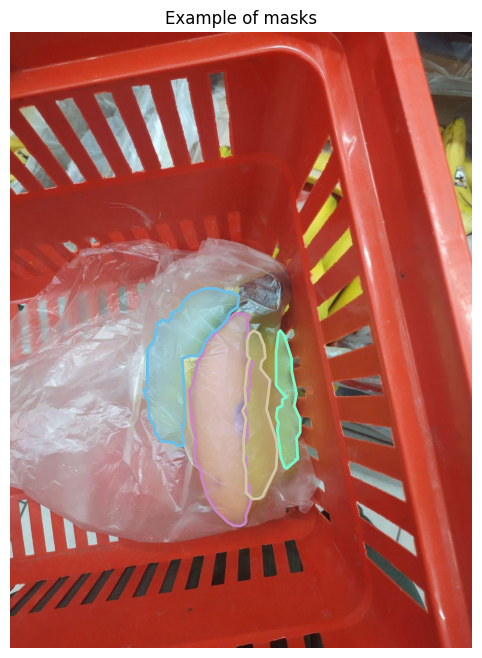

In [53]:
# Get a random image ID from the dataset
img_ids = coco.getImgIds()
img_id = img_ids[0]  # Change this to view different images

# Load image information
img_info = coco.loadImgs(img_id)[0]
img_path = f'{dataDir}/{dataType}/{img_info["file_name"]}'
img = cv2.imread(img_path)

# Load and display annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Display the image with annotations
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
coco.showAnns(anns)

plt.axis('off')
plt.title('Example of masks')
plt.show()
lables = [d['category_id'] for d in anns]

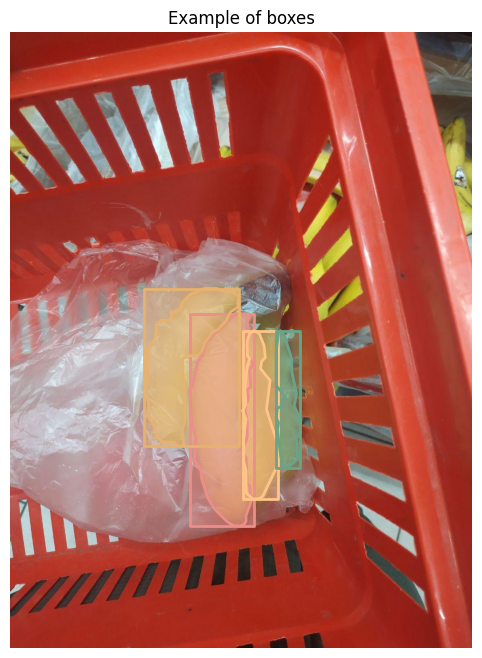

In [54]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
coco.showAnns(anns=anns, draw_bbox=True)

plt.axis('off')
plt.title('Example of boxes')
plt.show()

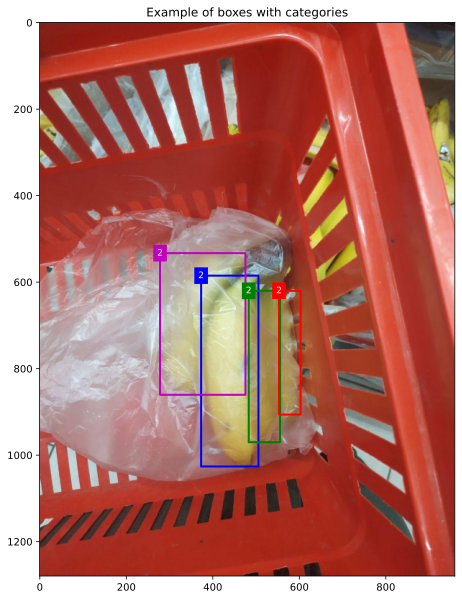

In [55]:
boxes = np.array([d['bbox'] for d in anns])
# boxes = d2l.box_center_to_corner(boxes)
d2l.set_figsize((10, 10))
fig = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Example of boxes with categories')
show_bboxes(fig.axes, boxes, labels=lables)

## Aspect ratios of bounding boxes

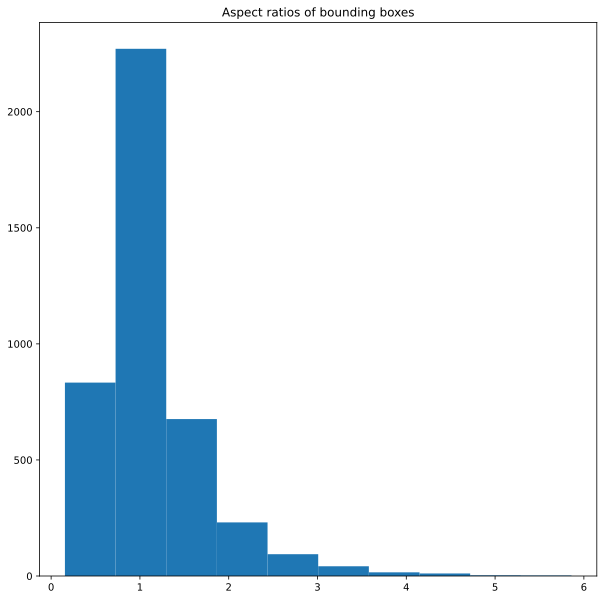

In [56]:
import numpy as np
counts, bins = np.histogram(bounding_box_aspect_ratio)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Aspect ratios of bounding boxes')
plt.show()

## Areas of bounding boxes

### Total area

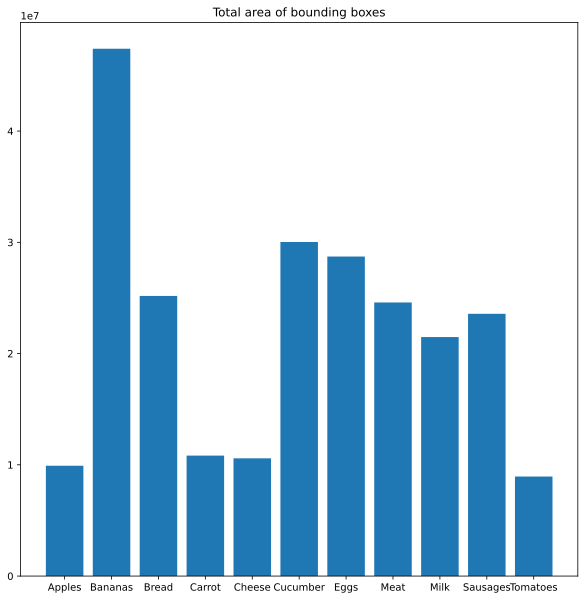

In [57]:
category_names = {}
for cat in coco.cats.values():
  category_names[cat['id']] = cat['name']
total_area = [sum(ls) for ls in bounding_box_area.values()]

categories = list(bounding_box_area.keys())
plt.bar(categories, total_area)
plt.xticks(categories, [category_names[j] for j in categories])
plt.title('Total area of bounding boxes')
plt.show()

### Mean area

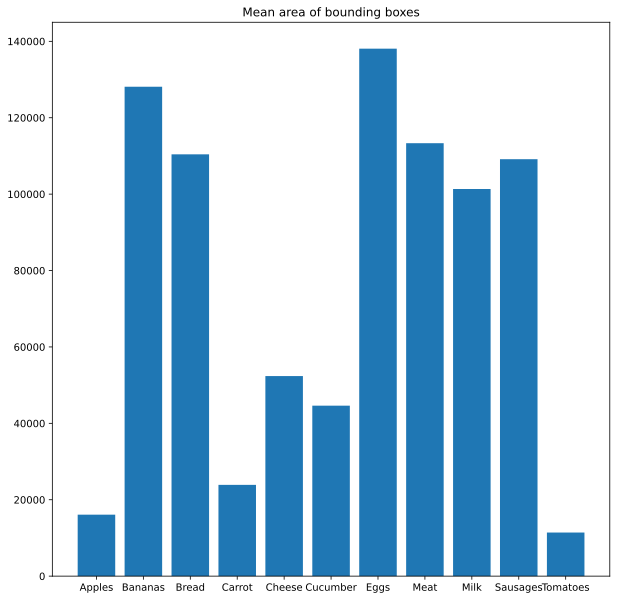

In [58]:
category_names = {}
for cat in coco.cats.values():
  category_names[cat['id']] = cat['name']
total_area = [np.mean(ls) for ls in bounding_box_area.values()]

categories = list(bounding_box_area.keys())
plt.bar(categories, total_area)
plt.xticks(categories, [category_names[j] for j in categories])
plt.title('Mean area of bounding boxes')
plt.show()

## Areas of masks

### Total area

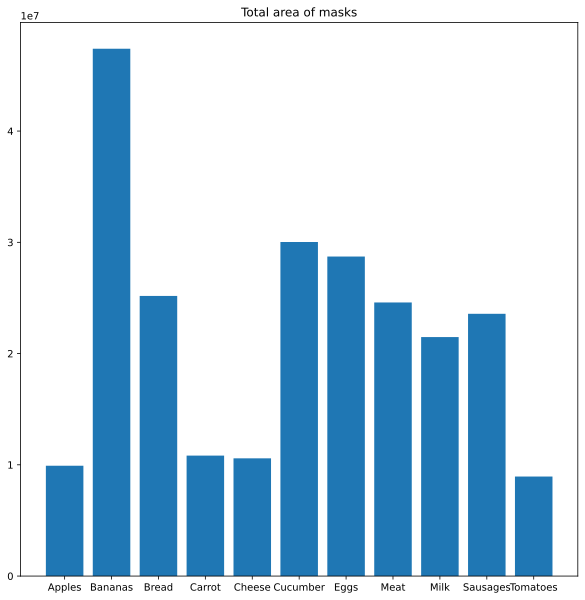

In [59]:
category_names = {}
for cat in coco.cats.values():
  category_names[cat['id']] = cat['name']
total_area = [sum(ls) for ls in mask_area.values()]

categories = list(mask_area.keys())
plt.bar(categories, total_area)
plt.xticks(categories, [category_names[j] for j in categories])
plt.title('Total area of masks')
plt.show()

### Mean area

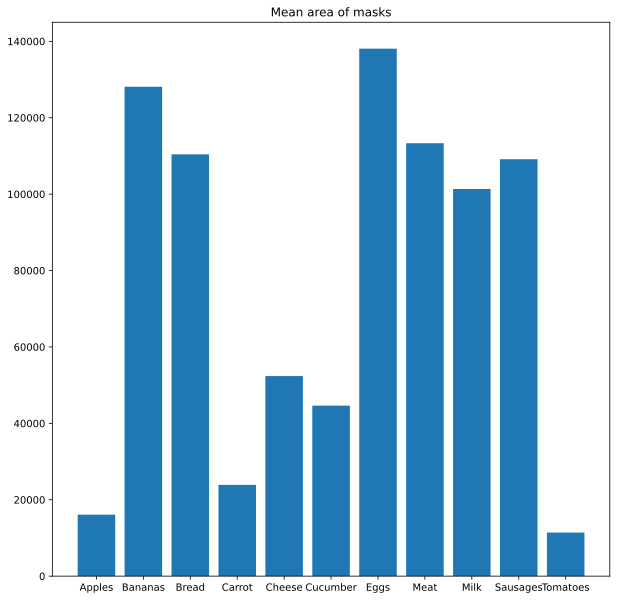

In [60]:
category_names = {}
for cat in coco.cats.values():
  category_names[cat['id']] = cat['name']
total_area = [np.mean(ls) for ls in mask_area.values()]

categories = list(mask_area.keys())
plt.bar(categories, total_area)
plt.xticks(categories, [category_names[j] for j in categories])
plt.title('Mean area of masks')
plt.show()

## Categories representation

Taken from roboflow

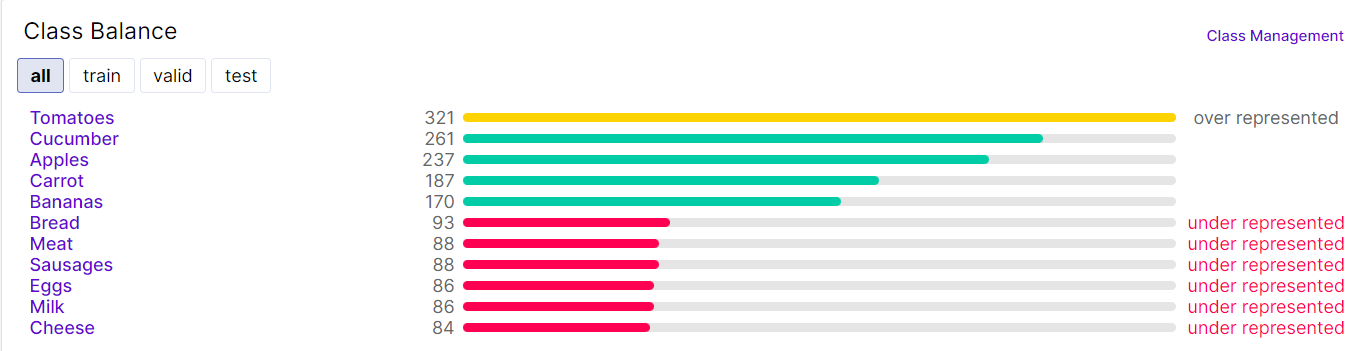

## Conclusion

Aspect ratio for bounding boxes are pretty normal. Even though there are some extreme values, it is not a problem, like these values appear because of difference in geometry of objects that we are detecting

Total areas of masks and bounding boxes shows that some classes are underrepresented. Therefore, we should add more objects of these specific categoreis to dataset. However, we should do this step after we will solve difference in mean area, for example by cropping images to enlarge specific objects

Category representation shows that tomatoes are overrepresented. However, area analysis shows that total area and mean area for tomatoes is pretty small, so in our dataset there are a lot of small tomato objects. We should fix that, for example, by cropping images with tomatoes. In addition, category representation shows underrepresented classes with pretty average areas (e.g. milk, meat, eggs), so we should give an extra attention for this categories during next data collection.